In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import functools as ft
from scipy import interpolate

# Set some formatting parameters for matplotlib parameters
matplotlib.rcParams.update({'font.size': 16})  # Font size
matplotlib.rc('text', usetex=True)             # Use Latex formatting for text
matplotlib.rc('font',family='Times New Roman') # Use Times New Roman font

In [2]:
# Create a list of years for which I have data
# Have data from 1990 until 2024
years_of_data = np.arange(1990,2025,1)

print(years_of_data)
n_years = len(years_of_data)

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024]


**Read in the available data**

In [3]:
# Read in LEGO set data
lego_df = pd.read_pickle('data/Lego_data.pkl')

**Add columns of data for the price per piece and price per weight**

In [4]:
# Add in columns of data for the price per piece for AU, US, UK and Germany (Euro)
lego_df['AU_PPP'] = lego_df['AURetailPrice']/lego_df['Pieces']
lego_df['US_PPP'] = lego_df['USRetailPrice']/lego_df['Pieces']
lego_df['UK_PPP'] = lego_df['UKRetailPrice']/lego_df['Pieces']
lego_df['DE_PPP'] = lego_df['DERetailPrice']/lego_df['Pieces']

# Add in columns of data for the price per weight for AU, US, UK and Germany (Euro)
lego_df['AU_PPW'] = lego_df['AURetailPrice']/lego_df['Weight (in Grams)']
lego_df['US_PPW'] = lego_df['USRetailPrice']/lego_df['Weight (in Grams)']
lego_df['UK_PPW'] = lego_df['UKRetailPrice']/lego_df['Weight (in Grams)']
lego_df['DE_PPW'] = lego_df['DERetailPrice']/lego_df['Weight (in Grams)']

**Read in historical median salary and exchange rate information from various sources**

In [5]:
# Read in Australian median weekly salary from the ABS
df_salary_AU = pd.read_csv("data/median_weekly_salary_AU.csv",
                       names=['Year','Weekly Salary'])

median_AU_salary = df_salary_AU['Weekly Salary'].values.tolist()

**Create subsets of data for the PPP and PPW over the past 3 years (2022 - 2024)**

In [6]:
# Create a dataframe of all LEGO sets for the past 3 years
select_data_3yrs = lego_df[(lego_df['YearFrom'] >= 2022) & (lego_df['YearFrom'] <= 2024)].copy()

# Create a separate subset of LEGO sets for the past 3 years excluding various themes
# that may skew the parts per piece (i.e. large numbers of 1x1 studs decreasing the PPP from the mean)
select_data_3yrs_limited = lego_df[(lego_df['YearFrom'] >= 2022) & (lego_df['YearFrom'] <= 2024)
                                    & (lego_df['Theme'] != 'Art') & (lego_df['Theme'] != 'Dots')
                                    & (lego_df['Theme'] != 'Technic')].copy()

**Plot the number of pieces in a set by the Australian retail price**

Overlay on the scatter plot, a linear graph of the form y = mx, with a gradient highlighting the quantity price per piece (PPP: the set price divided by the number of pieces in the set. Also calculate relevant metrics such as the correlation coefficient and R^2 coefficient

Correlation Matrix
[[1.         0.87294822]
 [0.87294822 1.        ]]
Median, Mean and STD for Price per piece (PPP)
0.15383431952662724 0.1670146609445676 0.07046208899844053
Gradient (m) and offset (c) for linear curve of the form y = mx + c
0.12912881377440366 17.307556445295454
R^2 coefficient (PPP)
0.7616670439595049
R^2 coefficient (y=mx+c)
0.8427494033984034


/Users/greigb/miniconda3/envs/data-science/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/greigb/miniconda3/envs/data-science/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/greigb/miniconda3/envs/data-science/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/greigb/miniconda3/envs/data-science/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/greigb/miniconda3/envs/data-science/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

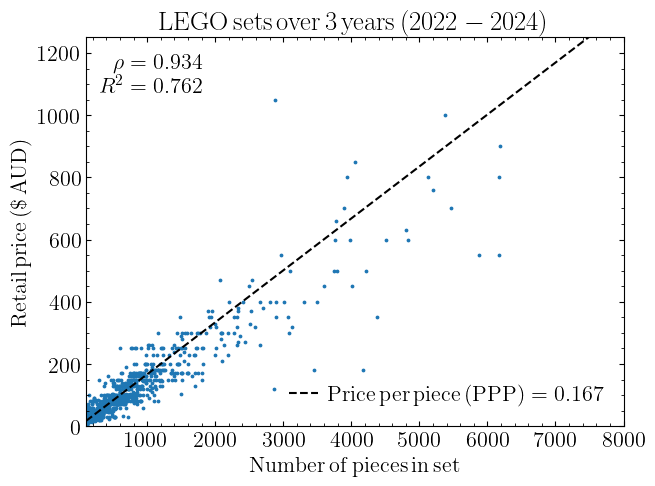

In [7]:
# Calculate the correlation coefficients for LEGO pieces vs Australian retail price
corr_matrix_pieces = np.corrcoef(lego_df['Pieces'], lego_df['AURetailPrice'])
print('Correlation Matrix')
print(corr_matrix_pieces)

# Calculate mean, median and standard deviation
median_PPP = np.median(select_data_3yrs['AU_PPP'].values.tolist())
mean_PPP = np.mean(select_data_3yrs['AU_PPP'].values.tolist())
std_PPP = np.std(select_data_3yrs['AU_PPP'].values.tolist())
print('Median, Mean and STD for Price per piece (PPP)')
print(median_PPP,mean_PPP,std_PPP)

# Number of points for exploratory linear correlation between the LEGO pieces in a set and the price
n_points = 100

# Arrays for the x, y data
xvals_PPP = np.zeros(n_points)
yvals_PPP = np.zeros(n_points)

# Consider a minimum piece count of 100 and a maximum piece count of 8000
pieces_min = 100.
pieces_max = 8000.

# Construct the linear correlation (y = mx)
for i in range(n_points):
    xvals_PPP[i] = pieces_min + (pieces_max - pieces_min)*float(i)/(float(n_points)-1.)
    # yvals_PPP[i] = median_PPP * xvals_PPP[i]
    yvals_PPP[i] = mean_PPP * xvals_PPP[i]

# Consider bins of 1000 pieces for splitting up the available data
arbitrary_bins_pieces = [[100,1000],[1000,2000],[2000,3000],[3000,4000],[4000,5000],
                  [5000,6000],[6000,7000],[7000,8000]]

# Number of bins
n_bins_pieces = len(arbitrary_bins_pieces)
# Bin centres
bin_centres_pieces = [1000*i+500 for i in range(n_bins_pieces)]

# Mean and standard deviation within each of the above bins
per_bin_pieces = np.zeros(n_bins_pieces)
std_per_bin_pieces = np.zeros(n_bins_pieces)

# Loop over all LEGO piece bins
for i_bin in range(n_bins_pieces):
    # Grab all LEGO set information within the current bin
    select_data = select_data_3yrs[(select_data_3yrs['Pieces'] >= arbitrary_bins_pieces[i_bin][0]) & 
                                        (select_data_3yrs['Pieces'] < arbitrary_bins_pieces[i_bin][1])].copy()

    # Determine the mean and standard deviation of the data within the current bin width
    per_bin_pieces[i_bin] = np.mean(select_data['AURetailPrice'].values.tolist())
    std_per_bin_pieces[i_bin] = np.std(select_data['AURetailPrice'].values.tolist())

# Fit a linear curve to the data of the form y = mx + c
gradient_pieces, offset_pieces = np.polyfit(select_data_3yrs['Pieces'],select_data_3yrs['AURetailPrice'], 1)
print('Gradient (m) and offset (c) for linear curve of the form y = mx + c')
print(gradient_pieces,offset_pieces)

# Determine the R^2 coefficient to quantify quality of fit of the linear line to the available data
mean_prices = np.mean(select_data_3yrs['AURetailPrice'].values.tolist())
# For PPP (y = mx)
price_vals = mean_PPP * np.array(select_data_3yrs['Pieces'].values.tolist())
# For line of the form y = mx + c
price_vals_alt = offset_pieces + gradient_pieces * np.array(select_data_3yrs['Pieces'].values.tolist())

# Calculate the residual squared sum for determining the R^2 coefficient
residual_square_sum = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - price_vals))
residual_square_sum_alt = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - price_vals_alt))

# Total sum (denominator) of the formula is independent of our functional form, so calculate once
total_square_sum = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - mean_prices))

r_squared_PPP = 1. - residual_square_sum/total_square_sum
r_squared_PPP_alt = 1. - residual_square_sum_alt/total_square_sum
print('R^2 coefficient (PPP)')
print(r_squared_PPP)

print('R^2 coefficient (y=mx+c)')
print(r_squared_PPP_alt)

# For modifying the whitespace around the figure
sub_adj_l = 0.12
sub_adj_b = 0.12
sub_adj_r = 0.96
sub_adj_t = 0.93
sub_adj_w = 0.02
sub_adj_h = 0.02

# List to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Adjust the figure according to the above parameters
plt.subplots_adjust(sub_adj_l,sub_adj_b,sub_adj_r,sub_adj_t,sub_adj_w,sub_adj_h)

# Add scatter plot for all available data (Pieces and Retail price) for the past 3 years
plt.scatter(select_data_3yrs['Pieces'], select_data_3yrs['AURetailPrice'],s=3)
# Draw and store the line information that corresponds to the PPP (y = mx)
lines_d1, = plt.plot(xvals_PPP,yvals_PPP,color='k',linestyle='dashed')

# Label highlighting the mean PPP and store the line information for display in the legend
label_panel.append(r"${\rm Price\,per\,piece\,(PPP) = %.3g}$"%(mean_PPP))
handles_panel.append((lines_d1,))

# Draw legend from handle information
plt.legend(handles_panel, label_panel,loc=4, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Limit the x (number of pieces) and y (retail price) range for the figure
plt.xlim(100,8000)
plt.ylim(0,1250)

# Draw x and y axis ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Add text label for the correlation coefficient and the R^2 coefficient
plt.text(500,1150,r"$\rho=%.3g$"%(np.sqrt(corr_matrix_pieces[0][1])))
plt.text(300,1075,r"$R^{2}=%.3g$"%(r_squared_PPP))

# x, y labels for the figure and also a title
plt.xlabel(r"${\rm Number\,of\,pieces\,in\,set}$")
plt.ylabel(r"${\rm Retail\,price\,(\$\,AUD)}$")
plt.title(r"${\rm LEGO\,sets\,over\,3\,years\,(2022-2024)}$")
plt.savefig("scatter_pieces.png",dpi=300)

**Plot the number of pieces in a set by the Australian retail price**

This time we now consider two linear relationships. Firstly, the PPP of the data (of the form y = mx).
Secondly, a better fit to the data provided by the form y = mx + c.

Also calculate relevant metrics such as the correlation coefficient and R^2 coefficient

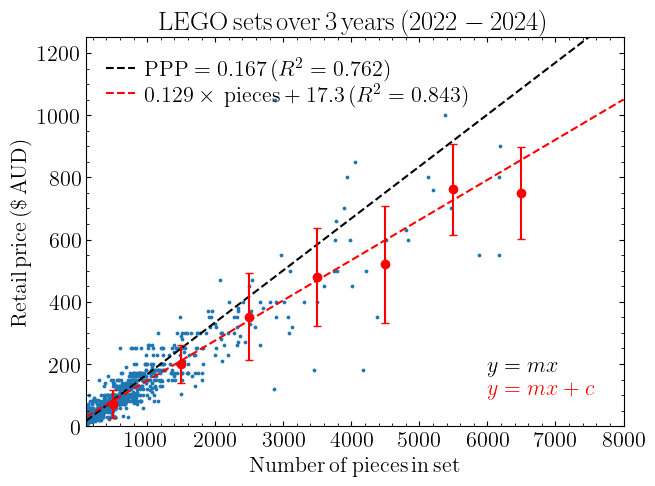

In [8]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Re-adjust figure size
plt.subplots_adjust(sub_adj_l,sub_adj_b,sub_adj_r,sub_adj_t,sub_adj_w,sub_adj_h)

# Scatter plot for all LEGO sets within the selected data set (number of pieces by Australian retail price)
plt.scatter(select_data_3yrs['Pieces'], select_data_3yrs['AURetailPrice'],s=3)
# Linear curve of the form y = mx (i.e. PPP)
lines_d1, = plt.plot(xvals_PPP,yvals_PPP,color='k',linestyle='dashed')

# Label containing the mean and R^2 for the PPP (y = mx)
label_panel.append(r"${\rm PPP = %.3g}\, (R^{2} = %.3g)$"%(mean_PPP,r_squared_PPP))
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a separate line of the form y = mx + c (to highlight an improved fit to the available data)
# Purely for visual demonstration and not used for any real analyses
lines_d1, = plt.plot(xvals_PPP,
                     [offset_pieces + gradient_pieces*xvals_PPP[i] for i in range(n_points)],
                     color='red',linestyle='dashed')

# Label summarising the equation of the improved linear fit to the data (including R^2 coefficient)
label_panel.append(r"${\rm %.3g\times\,pieces + %.3g}\, (R^{2} = %.3g)$"%(gradient_pieces,offset_pieces,r_squared_PPP_alt))
# Handle of the line for the legend
handles_panel.append((lines_d1,))

# Add error bars for the mean (and standard deviation) for the PPP within each of the earlier determined bins of LEGO pieces
# This serves as a visualisation of the data, and how this improved linear fit is a better match to the data
for i_bin in range(n_bins_pieces):
    # Plot points
    plt.plot(bin_centres_pieces[i_bin],per_bin_pieces[i_bin],color='red',marker='o')
    # Plot error bars
    plt.errorbar(bin_centres_pieces[i_bin], per_bin_pieces[i_bin], yerr=std_per_bin_pieces[i_bin], capsize=3, ecolor = "red")

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=2, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(100,8000)
plt.ylim(0,1250)

# Text labels to highlight the form of the different linear curves
plt.text(6000,175,r"$y=mx$",color='black')
plt.text(6000,100,r"$y=mx+c$",color='red')

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Text label to provide the correlation coefficient for the PPP (y=mx)
# plt.text(500,950,r"$\rho=%.3g$"%(np.sqrt(corr_matrix_pieces[0][1])))

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Number\,of\,pieces\,in\,set}$")
plt.ylabel(r"${\rm Retail\,price\,(\$\,AUD)}$")
plt.title(r"${\rm LEGO\,sets\,over\,3\,years\,(2022-2024)}$")
plt.savefig("scatter_pieces_corr.png",dpi=300)

**Plot the weight of a LEGO set by the Australian retail price**

Overlay on the scatter plot, a linear graph of the form y = mx, with a gradient highlighting the quantity price per weight (PPW: the LEGO set price divided by the weight of the set. Also calculate relevant metrics such as the correlation coefficient and R^2 coefficient

Correlation Matrix
[[1.         0.96517721]
 [0.96517721 1.        ]]
Median and Mean Price per weight (PPW) removing select LEGO themes
0.10855850422195416 0.11385958126682501
Gradient (m) and offset (c) for linear curve of the form y = mx + c
0.09923339485716745 8.387652048458989
R^2 coefficient
0.9078261195025931
R^2 coefficient (y=mx+c)
0.9315670488480408


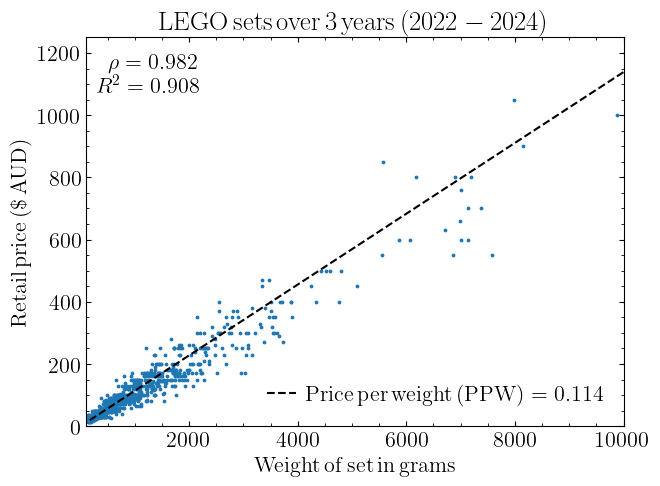

In [9]:
# Calculate the correlation matrix
corr_matrix_weight = np.corrcoef(select_data_3yrs['Weight (in Grams)'], select_data_3yrs['AURetailPrice'])
print('Correlation Matrix')
print(corr_matrix_weight)

# Calculate mean, median and standard deviation
median_PPW = np.median(select_data_3yrs['AU_PPW'].values.tolist())
mean_PPW = np.mean(select_data_3yrs['AU_PPW'].values.tolist())
print('Median and Mean Price per weight (PPW) removing select LEGO themes')
print(median_PPW,mean_PPW)

# Arrays for the x, y data
xvals_PPW = np.zeros(n_points)
yvals_PPW = np.zeros(n_points)

weight_min = 1.
weight_max = 10000.

# Calculate data for a linear line of the form y = mx for the PPW
for i in range(n_points):
    xvals_PPW[i] = weight_min + (weight_max - weight_min)*float(i)/(float(n_points)-1.)
    # yvals_PPW[i] = median_PPW * xvals_PPW[i] # Switch to median
    yvals_PPW[i] = mean_PPW * xvals_PPW[i]

# Consider bins of 1000 (weight in grams) for splitting up the available data
arbitrary_bins_weight = [[100,1000],[1000,2000],[2000,3000],[3000,4000],[4000,5000],
                  [5000,6000],[6000,7000],[7000,8000],[8000,9000],[9000,10000]]

# Number of bins
n_bins_weight = len(arbitrary_bins_weight)
# Bin centres
bin_centres_weight = [1000*i+500 for i in range(n_bins_weight)]

# Mean and standard deviation within each of the above bins
per_bin_weight = np.zeros(n_bins_weight)
std_per_bin_weight = np.zeros(n_bins_weight)

# Loop over all LEGO piece bins
for i_bin in range(n_bins_weight):
    # Grab all LEGO set information within the current bin
    select_data = select_data_3yrs[(select_data_3yrs['Weight (in Grams)'] >= arbitrary_bins_weight[i_bin][0]) & 
                                        (select_data_3yrs['Weight (in Grams)'] < arbitrary_bins_weight[i_bin][1])].copy()
    
    # Determine the mean and standard deviation of the data within the current bin width
    per_bin_weight[i_bin] = np.mean(select_data['AURetailPrice'].values.tolist())
    std_per_bin_weight[i_bin] = np.std(select_data['AURetailPrice'].values.tolist())

# Fit a linear curve to the data of the form y = mx + c
gradient_weight, offset_weight = np.polyfit(select_data_3yrs['Weight (in Grams)'],select_data_3yrs['AURetailPrice'], 1)
print('Gradient (m) and offset (c) for linear curve of the form y = mx + c')
print(gradient_weight,offset_weight)

# Determine the R^2 coefficient to quantify quality of fit of the linear line to the available data
mean_prices = np.mean(select_data_3yrs['AURetailPrice'].values.tolist())
# For PPW (y = mx)
price_vals = mean_PPW * np.array(select_data_3yrs['Weight (in Grams)'].values.tolist())
# For line of the form y = mx + c
price_vals_alt = offset_weight + gradient_weight * np.array(select_data_3yrs['Weight (in Grams)'].values.tolist())

# Calculate the residual squared sum for determining the R^2 coefficient
residual_square_sum = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - price_vals))
residual_square_sum_alt = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - price_vals_alt))

# Total sum (denominator) of the formula is independent of our functional form, so calculate once
total_square_sum = np.sum(np.square(select_data_3yrs['AURetailPrice'].values.tolist() - mean_prices))

r_squared_PPW = 1. - residual_square_sum/total_square_sum
r_squared_PPW_alt = 1. - residual_square_sum_alt/total_square_sum
print('R^2 coefficient')
print(r_squared_PPW)

print('R^2 coefficient (y=mx+c)')
print(r_squared_PPW_alt)

# List to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Adjust the figure according to the above parameters
plt.subplots_adjust(sub_adj_l,sub_adj_b,sub_adj_r,sub_adj_t,sub_adj_w,sub_adj_h)

# Add scatter plot for all available data (Weight in grams and Retail price) for the past 3 years
plt.scatter(select_data_3yrs['Weight (in Grams)'], select_data_3yrs['AURetailPrice'],s=3)
# Draw and store the line information that corresponds to the PPW (y = mx)
lines_d1, = plt.plot(xvals_PPW,yvals_PPW,color='k',linestyle='dashed')

# Label highlighting the mean PPW and store the line information for display in the legend
label_panel.append(r"${\rm Price\,per\,weight\,(PPW) = %.3g}$"%(mean_PPW))
handles_panel.append((lines_d1,))

# Draw legend from handle information
plt.legend(handles_panel, label_panel,loc=4, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Add text label for the correlation coefficient and the R^2 coefficient
plt.text(500,1150,r"$\rho=%.3g$"%(np.sqrt(corr_matrix_weight[0][1])))
plt.text(300,1075,r"$R^{2}=%.3g$"%(r_squared_PPW))

# Limit the x (weight in grams) and y (retail price) range for the figure
plt.xlim(100,10000)
plt.ylim(0,1250)

# Draw x and y axis ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# x, y labels for the figure and also a title
plt.xlabel(r"${\rm Weight\,of\,set\,in\,grams}$")
plt.ylabel(r"${\rm Retail\,price\,(\$\,AUD)}$")
plt.title(r"${\rm LEGO\,sets\,over\,3\,years\,(2022-2024)}$")
plt.savefig("scatter_weight.png",dpi=300)

**Plot the set weight (in grams) by the Australian retail price**

This time we now consider two linear relationships. Firstly, the PPW of the data (of the form y = mx).
Secondly, a better fit to the data provided by the form y = mx + c.

Also calculate relevant metrics such as the correlation coefficient and R^2 coefficient

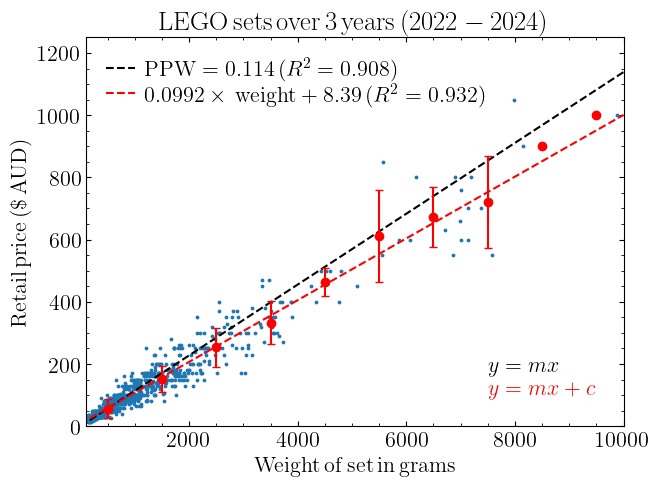

In [10]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Re-adjust figure size
plt.subplots_adjust(sub_adj_l,sub_adj_b,sub_adj_r,sub_adj_t,sub_adj_w,sub_adj_h)

# Scatter plot for all LEGO sets within the selected data set (set weight in grams by Australian retail price)
plt.scatter(select_data_3yrs['Weight (in Grams)'], select_data_3yrs['AURetailPrice'],s=3)
# Linear curve of the form y = mx (i.e. PPW)
lines_d1, = plt.plot(xvals_PPW,yvals_PPW,color='k',linestyle='dashed')

# Label containing the mean and R^2 for the PPW (y = mx)
label_panel.append(r"${\rm PPW = %.3g}\, (R^{2} = %.3g)$"%(mean_PPW,r_squared_PPW))
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a separate line of the form y = mx + c (to highlight an improved fit to the available data)
# Purely for visual demonstration and not used for any real analyses
lines_d1, = plt.plot(xvals_PPW,[offset_weight + gradient_weight*xvals_PPW[i] for i in range(n_points)],color='red',linestyle='dashed')

# Label summarising the equation of the improved linear fit to the data (including R^2 coefficient)
label_panel.append(r"${\rm %.3g\times\,weight + %.3g}\, (R^{2} = %.3g)$"%(gradient_weight,offset_weight,r_squared_PPW_alt))
# Handle of the line for the legend
handles_panel.append((lines_d1,))

# Add error bars for the mean (and standard deviation) for the PPW within each of the earlier determined bins of LEGO weight
# This serves as a visualisation of the data, and how this improved linear fit is a better match to the data
for i_bin in range(n_bins_weight):
    # Plot points
    plt.plot(bin_centres_weight[i_bin],per_bin_weight[i_bin],color='red',marker='o')
    # Plot error bars    
    plt.errorbar(bin_centres_weight[i_bin], per_bin_weight[i_bin], yerr=std_per_bin_weight[i_bin], capsize=3, ecolor = "red")

# Set the x and y values for the figure
plt.xlim(100,10000)
plt.ylim(0,1250)

# Text labels to highlight the form of the different linear curves
plt.text(7500,175,r"$y=mx$",color='black')
plt.text(7500,100,r"$y=mx+c$",color='red')

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=2, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Weight\,of\,set\,in\,grams}$")
plt.ylabel(r"${\rm Retail\,price\,(\$\,AUD)}$")
plt.title(r"${\rm LEGO\,sets\,over\,3\,years\,(2022-2024)}$")
plt.savefig("scatter_weight_corr.png",dpi=300)

**Determine PPP and PPW information as a function of calendar year**

Here, we want to investigate how our two metrics, PPP and PPW vary as a function of year that the LEGO sets were released. Therefore, split the data by year and determine the information

In [11]:
# Arrays to hold the yearly mean and median information for the PPP and PPW
# Index two corresponds to the two metrics (PPP; 0) and (PPW; 1)
au_pp_mean_all = np.zeros((2,n_years))
au_pp_median_all = np.zeros((2,n_years))

# Arrays to hold the median piece count, LEGO set weight and price as a function of year
# Indexing corresponds to; 0 = number of pieces, 1 = set weight and 2 = price
au_median_all = np.zeros((3,n_years))

# An array to hold the number of sets within the given year
total_in_year = np.zeros(n_years)

# Loop over all available years of LEGO data individually
for i_year in range(n_years):
    # Grab a dataframe for the current year
    set_scatter_yr = lego_df[lego_df['YearFrom'] == years_of_data[i_year]].copy()
    # Convert the price per piece (PPP) data to a list
    current_list = set_scatter_yr['AU_PPP'].values.tolist()

    # Determine the total number of available LEGO sets within the current year
    total_in_year[i_year] = len(set_scatter_yr)

    # Determine the mean and median of the PPP for the given year
    au_pp_mean_all[0][i_year] = np.mean(current_list)
    au_pp_median_all[0][i_year] = np.median(current_list)

    # Calculate the median number of pieces, set weight and Australian retail price of sets within the current year
    au_median_all[0][i_year] = np.median(set_scatter_yr['Pieces'].values.tolist())
    au_median_all[1][i_year] = np.median(set_scatter_yr['Weight (in Grams)'].values.tolist())
    au_median_all[2][i_year] = np.median(set_scatter_yr['AURetailPrice'].values.tolist())

    # Convert the price per weight (PPW) data to a list
    current_list = set_scatter_yr['AU_PPW'].values.tolist()

    # Calculate the mean and median of the PPW
    au_pp_mean_all[1][i_year] = np.mean(current_list)
    au_pp_median_all[1][i_year] = np.median(current_list)

**Plot the price per piece (PPP) as a function of year**

Includes curves for both the raw PPP and the PPP when adjusted for the median Australian salary.

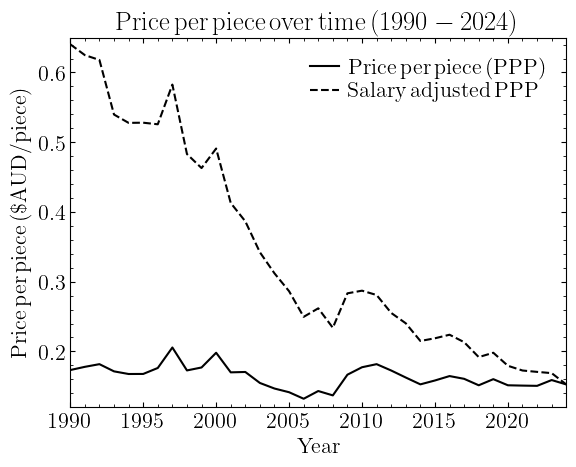

In [12]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Plot a black, solid line for the median PPP as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_pp_median_all[0],color='k')

# Label denoting the median PPP
label_panel.append(r"${\rm Price\,per\,piece\,(PPP)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Calculate the normalisation to account for the changes in median Australian salary over time
# We divide the median PPP by the median salary. Therefore, to correctly normalise, we divide my
# the present day salary. This ensures earlier salaries are correctly inflation adjusted
normalisation = median_AU_salary[-1]

# Plot a black, dashed line for the salary adjusted median PPP
lines_d1, = plt.plot(years_of_data,normalisation*au_pp_median_all[0]/median_AU_salary,color='k',linestyle='dashed')

# Label denoting the salary adjusted PPP
label_panel.append(r"${\rm Salary\,adjusted\,PPP}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1990,2024)
plt.ylim(0.12,0.65)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Price\,per\,piece\,(\$AUD/piece)}$")
plt.title(r"${\rm Price\,per\,piece\,over\,time\,(1990-2024)}$")
plt.savefig("PPP_per_year.png",dpi=300)

**Plot the price per weight (PPW) as a function of year**

Includes curves for both the raw PPW and the PPW when adjusted for the median Australian salary.

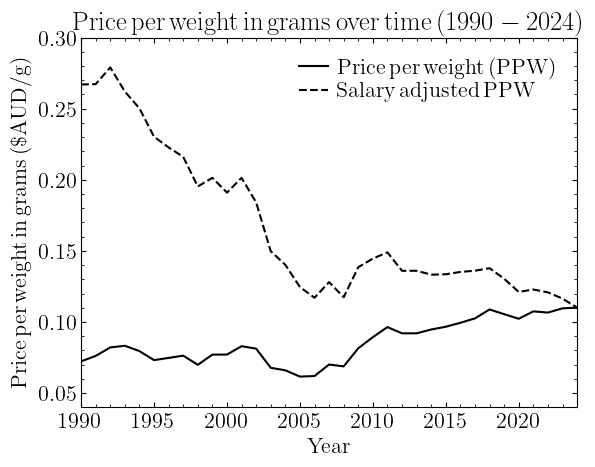

In [13]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Plot a black, solid line for the median PPW as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_pp_median_all[1],color='k')

# Label denoting the median PPW
label_panel.append(r"${\rm Price\,per\,weight\,(PPW)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Calculate the normalisation to account for the changes in median Australian salary over time
# We divide the median PPW by the median salary. Therefore, to correctly normalise, we divide my
# the present day salary. This ensures earlier salaries are correctly inflation adjusted
normalisation = median_AU_salary[-1]

# Plot a black, dashed line for the salary adjusted median PPW
lines_d1, = plt.plot(years_of_data,normalisation*au_pp_median_all[1]/median_AU_salary,color='k',linestyle='dashed')

# Label denoting the salary adjusted PPW
label_panel.append(r"${\rm Salary\,adjusted\,PPW}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1990,2024)
plt.ylim(0.04,0.3)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Price\,per\,weight\,in\,grams\,(\$AUD/g)}$")
plt.title(r"${\rm Price\,per\,weight\,in\,grams\,over\,time\,(1990-2024)}$")
plt.savefig("PPW_per_year.png",dpi=300)

**Plot the median set price as a function of year**

Includes curves for both the raw median set price and the median set price when adjusted for the median Australian salary.

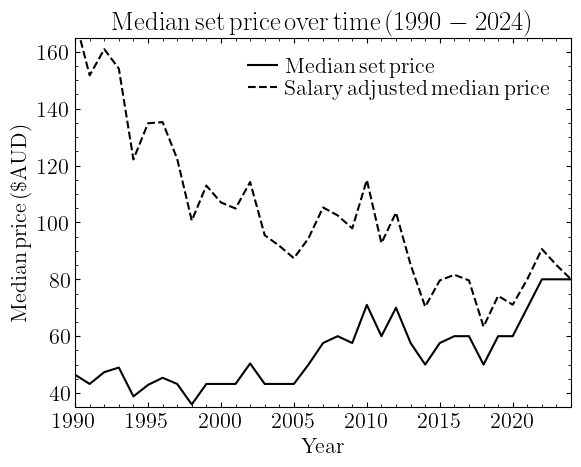

In [14]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Plot a black, solid line for the median set price as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_median_all[2],color='k')

# Label denoting the median set price
label_panel.append(r"${\rm Median\,set\,price}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Calculate the normalisation to account for the changes in median Australian salary over time
# We divide the median PPW by the median salary. Therefore, to correctly normalise, we divide my
# the present day salary. This ensures earlier salaries are correctly inflation adjusted
normalisation = median_AU_salary[-1]

# Plot a black, dashed line for the salary adjusted median set price
lines_d1, = plt.plot(years_of_data,normalisation*au_median_all[2]/median_AU_salary,color='k',linestyle='dashed')

# Label denoting the salary adjusted median set price
label_panel.append(r"${\rm Salary\,adjusted\,median\,price}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1990,2024)
plt.ylim(35.,165.)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Median\,price\,(\$AUD)}$")
plt.title(r"${\rm Median\,set\,price\,over\,time\,(1990-2024)}$")
plt.savefig("Median_price_peryr.png",dpi=300)

**Plot the median set weight as a function of year**

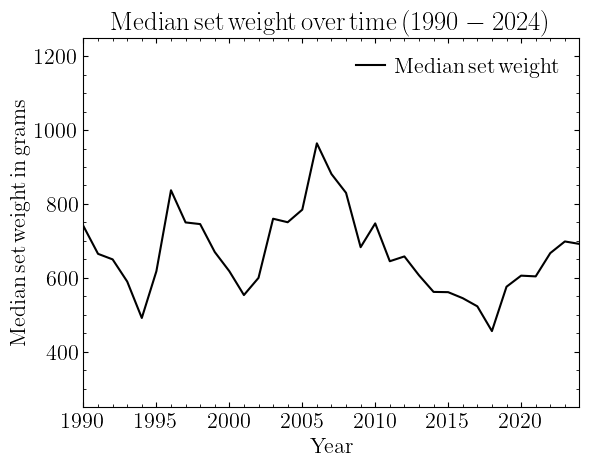

In [15]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Plot a black, solid line for the median set weight as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_median_all[1],color='k')

# Label denoting the median set weight
label_panel.append(r"${\rm Median\,set\,weight}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1990,2024)
plt.ylim(250.,1250.)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Median\,set\,weight\,in\,grams}$")
plt.title(r"${\rm Median\,set\,weight\,over\,time\,(1990-2024)}$")
plt.savefig("Median_weight_peryr.png",dpi=300)

**Plot the estimated price of a LEGO set as a function of calendar**

Here I compare the true median set price compared to an estimate of LEGO set prices using our PPW. For this, I simply multiply the median PPW by the median LEGO set weight as a function of calendar year

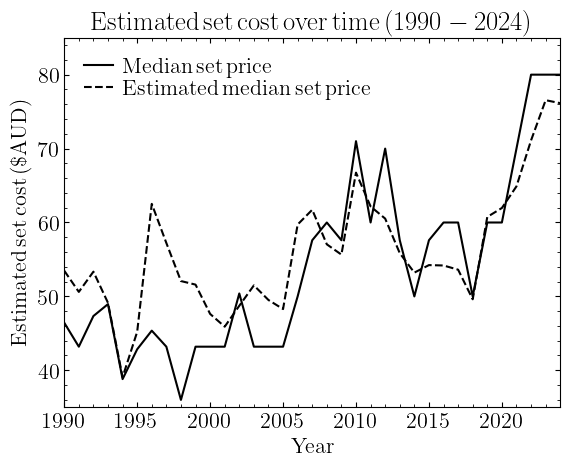

In [16]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Plot a black, solid line for the median set price as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_median_all[2],color='k')

# Label denoting the median set price
label_panel.append(r"${\rm Median\,set\,price}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Plot a black, dashed line for the salary adjusted median set price
# Determined by multiplying the median PPW by the median set weight as a function of calendar year
lines_d1, = plt.plot(years_of_data,au_median_all[1]*au_pp_median_all[1],color='k',linestyle='dashed')

# Label denoting the estimated median set price
label_panel.append(r"${\rm Estimated\,median\,set\,price}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=2, frameon=False, handlelength = 1.3, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1990,2024)
plt.ylim(35.,85.)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Estimated\,set\,cost\,(\$AUD)}$")
plt.title(r"${\rm Estimated\,set\,cost\,over\,time\,(1990-2024)}$")
plt.savefig("Estimated_cost_peryr.png",dpi=300)

**Estimate the growth in the number of LEGO sets in a given calendar year**

Here, I calculate the total number of LEGO sets containing a piece count between a given threshold (e.g. between 1000 and 2000 pieces) and also a set weight between a given threshold (e.g. between 1000 and 2000 grams). Over time, I expect to see an increase in LEGO sets with larger piece counts and/or set weights

In [17]:
# Set the edges for the bins of number of pieces
edges_low = np.arange(2000,11000,1000)
# Set the bin width for bar graph
bin_width = 1000
bin_edges = []
# Determine the edge values for the columns of the bar chart
for i in range(len(edges_low)):
    bin_edges.append([edges_low[i],edges_low[i]+bin_width])

# Empty numpy arrays to hold the number of bins, and the number of LEGO sets within a given number of pieces or weight
n_bins_hist = len(bin_edges)
n_above_pieces = np.zeros((n_years,n_bins_hist))
n_above_weight = np.zeros((n_years,n_bins_hist))

# Loop over the number of years
for i_year in range(n_years):
    # Loop over the number of available columns (bars) for our analysis
    for i_bin in range(n_bins_hist):
        # Obtain the LEGO sets within the current year between the current bin edges for LEGO piece count
        set_scatter_yr = lego_df[(lego_df['YearFrom'] == years_of_data[i_year]) & 
                                        (lego_df['Pieces'] >= bin_edges[i_bin][0]) & 
                                        (lego_df['Pieces'] < bin_edges[i_bin][1])].copy()

        # Calculate the number of sets (by piece) within the current threshold for the current year
        n_above_pieces[i_year][i_bin] = len(set_scatter_yr['Pieces'])    

        # Obtain the LEGO sets within the current year between the current bin edges for LEGO set weight in grams
        set_scatter_yr = lego_df[(lego_df['YearFrom'] == years_of_data[i_year]) & 
                                        (lego_df['Weight (in Grams)'] >= bin_edges[i_bin][0]) & 
                                        (lego_df['Weight (in Grams)'] < bin_edges[i_bin][1])].copy()        

        # Calculate the number of sets (by weight) within the current threshold for the current year
        n_above_weight[i_year][i_bin] = len(set_scatter_yr['Weight (in Grams)'])
        

**Plot the cumulative bar chart for the number of LEGO sets ordered by piece count as a function of year**

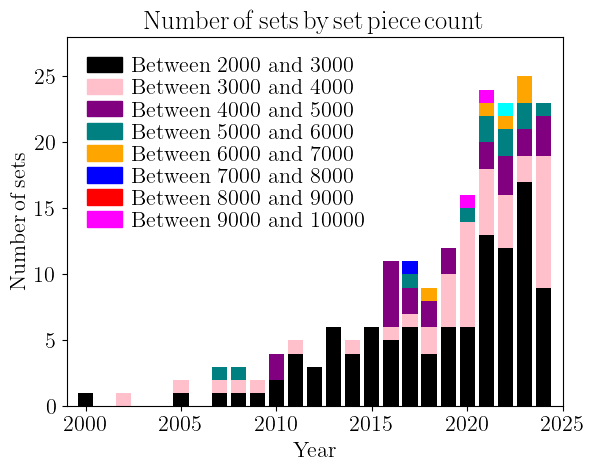

In [18]:
# Colour chart for the available number of bins for piece count or LEGO set weight
colors = ['Black','Pink','Purple','Teal','Orange','Blue','Red','Magenta','Cyan']

# Array to hold the location of the upper edge of the current bar (to plot on top of)
above = np.zeros(n_years)

# Loop over the number of individual bars
for i in range(len(colors)):
    if i == 0:
        # If first bar, draw bar
        plt.bar(years_of_data, n_above_pieces[:,i],color=colors[i])
        # Store the cumulative upper edge of the current bar
        above += n_above_pieces[:,i]
    else:
        # Draw the new bar of the current range, on top of the existing bars from previous ranges
        plt.bar(years_of_data, n_above_pieces[:,i], bottom = above,color=colors[i])
        # Update the upper edge to know where to plot the new bar on top of
        above += n_above_pieces[:,i]

# Create the colour bars and corresponding labels for the number of sets with a specific piece count
colours_bar = {'Between %s and %s'%(bin_edges[0][0],bin_edges[0][1]):'%s'%(colors[0])}         
for i in range(len(colors)-1):
  colours_bar.update({'Between %s and %s'%(bin_edges[i][0],bin_edges[i][1]):'%s'%(colors[i])})

# Create the label information for the various columns
labels = list(colours_bar.keys())
# Draw the columns information
handles = [plt.Rectangle((0,0),1,1, color=colours_bar[label]) for label in labels]
# Draw the legend for this figure
plt.legend(handles, labels,loc=2, frameon=False, handlelength = 1.6, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.xlim(1999,2025)
plt.ylim(0,28)

# Labels for the x, y and title of the figure
plt.title(r"${\rm Number\,of\,sets\,by\,set\,piece\,count}$")
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Number\,of\,sets}$")
plt.savefig("Histogram_price_peryr.png",dpi=300)

**Plot the cumulative bar chart for the number of LEGO sets ordered by set weight as a function of year**

Additionally, calculate the total number of sets above 3kg to demonstrate the growth in larger LEGO sets over time.

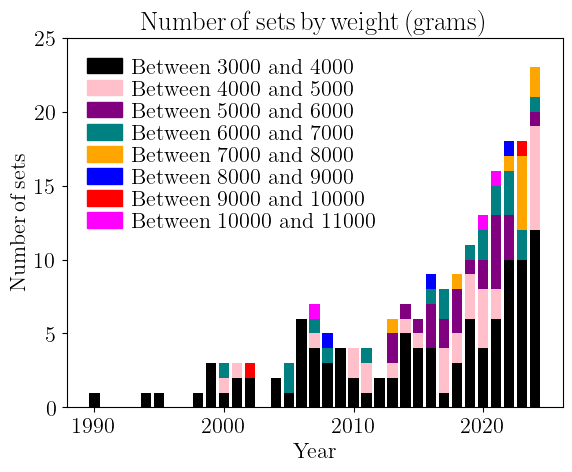

In [19]:
# Array to contain the upper edge of columns to be able to differentiate by colour
above = np.zeros(n_years)
# The total number of sets (by weight) above 3kg (above first bin)
# Done poorly, but basically counts the cumulative number above the first bin
total_in_bin_weight = np.zeros(n_years)

# Loop over all possible ranges of LEGO set weight
for i in range(n_bins_hist-1):
    if i == 0:
        # If first bar, plot bar
        plt.bar(years_of_data, n_above_weight[:,i+1],color=colors[i])
        # Record the upper edge for being able to plot future bars (of different colour) on top of 
        above = n_above_weight[:,i+1]
        # Record the total number of sets in the current weight limit (above the first bin, e.g. above 3kg)
        total_in_bin_weight += n_above_weight[:,i+1]
    else:
        # Plot new bar for newest range on top of the previous bars
        plt.bar(years_of_data, n_above_weight[:,i+1], bottom = above,color=colors[i])
        # Update the upper edge for future bar plotting
        above += n_above_weight[:,i+1]
        # Record the total number of sets in the current weoght threshold
        total_in_bin_weight += n_above_weight[:,i+1]

# Create the colour bars and corresponding labels for the number of sets with a specific set weight
colours_bar = {'Between %s and %s'%(bin_edges[1][0],bin_edges[1][1]):'%s'%(colors[0])}         
for i in range(len(colors)-1):
  colours_bar.update({'Between %s and %s'%(bin_edges[i+1][0],bin_edges[i+1][1]):'%s'%(colors[i])})

# Create the label information for the various columns
labels = list(colours_bar.keys())
# Draw the columns information
handles = [plt.Rectangle((0,0),1,1, color=colours_bar[label]) for label in labels]
# Draw the legend for this figure
plt.legend(handles, labels,loc=2, frameon=False, handlelength = 1.6, handletextpad=0.4, labelspacing=0.1)

# Set the x and y values for the figure
plt.ylim(0,25)

# Labels for the x, y and title of the figure
plt.title(r"${\rm Number\,of\,sets\,by\,weight\,(grams)}$")
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Number\,of\,sets}$")
plt.savefig("Histogram_price_peryr.png",dpi=300)

**Plot the percentage of sets above 3kg as a function of time**

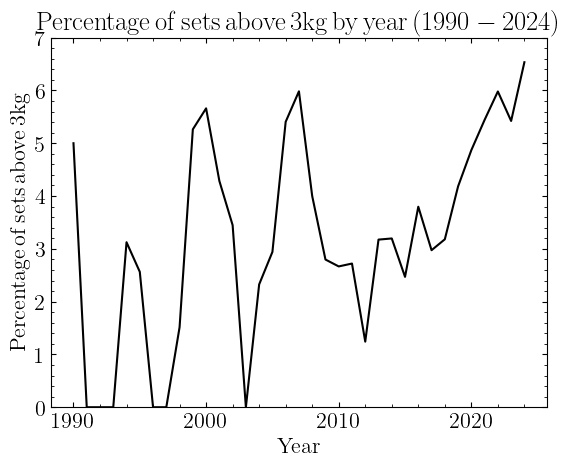

In [20]:
# Draw a black solid line for the percentage of LEGO sets above 3kg as a function of year
# Calculate the fraction by using the total above 3kg divided by the total number of sets in a given year.
# To obtain the percentage, multiply by 100.
plt.plot(years_of_data,100.*total_in_bin_weight/total_in_year,color='k')

# Set the x and y values for the figure
plt.ylim(0,7)

# Turn on all ticks including minor ticks
plt.tick_params(which='both', left=True, right=True, top=True, bottom=True, direction='in')
plt.minorticks_on()

# Labels for the x, y and title of the figure
plt.title(r"${\rm Percentage\,of\,sets\,above\,3kg\,by\,year\,(1990-2024)}$")
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Percentage\,of\,sets\,above\,3kg}$")
plt.savefig("Percentage_peryr.png",dpi=300)